<a href="https://colab.research.google.com/github/sehee020512/20242R0136COSE47402/blob/master/final%20project%2012.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preparation

In [1]:
!pip install pillow
!pip install transformers
!pip install matplotlib
!pip install timm

In [2]:
import kagglehub
import shutil
import os
import shutil
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch
import torch.nn as nn
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import torchvision
import torchvision.transforms as T
from sklearn.metrics import accuracy_score
import torch.optim as optim
import matplotlib.pyplot as plt
import time

In [3]:
path = kagglehub.dataset_download("kavyasreeb/hair-type-dataset")

print("Path to dataset files:", path)

100%|██████████| 175M/175M [00:08<00:00, 20.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kavyasreeb/hair-type-dataset/versions/1


In [4]:
# 원본 데이터 경로
source_path = "/root/.cache/kagglehub/datasets/kavyasreeb/hair-type-dataset/versions/1"

# 복사할 대상 경로
destination_path = "/content/hair-type-dataset"

# 데이터 복사
try:
    shutil.copytree(source_path, destination_path)
    print(f"데이터가 {destination_path}에 복사되었습니다.")
except Exception as e:
    print(f"복사 실패: {e}")

데이터가 /content/hair-type-dataset에 복사되었습니다.


In [5]:
# 데이터 경로 설정
dataset_dir = "/content/hair-type-dataset/data"  # 클래스별 이미지가 있는 디렉토리
train_dir = "/content/train"  # train 데이터 저장 경로
val_dir = "/content/val"  # validation 데이터 저장 경로
test_dir = "/content/test"  # test 데이터 저장 경로

# train/validation/test 디렉토리 생성
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# 이미지 확장자 필터
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')

# 클래스별 train/validation/test 데이터 분리
train_split_ratio = 0.7  # Train 70%
val_split_ratio = 0.2    # Validation 20%
test_split_ratio = 0.1   # Test 10%

for category in os.listdir(dataset_dir):
    category_path = os.path.join(dataset_dir, category)
    if not os.path.isdir(category_path):
        continue  # 디렉토리가 아니면 건너뜀

    # 클래스별 이미지 파일 가져오기
    images = [img for img in os.listdir(category_path) if img.lower().endswith(valid_extensions)]

    # 이미지가 없으면 건너뜀
    if len(images) == 0:
        print(f"'{category}' 폴더에 이미지가 없습니다. 건너뜁니다.")
        continue

    # train/validation/test로 분리
    train_images, temp_images = train_test_split(images, test_size=(1 - train_split_ratio), random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=(test_split_ratio / (test_split_ratio + val_split_ratio)), random_state=42)

    # 클래스별 train/validation/test 디렉토리 생성
    train_category_dir = os.path.join(train_dir, category)
    val_category_dir = os.path.join(val_dir, category)
    test_category_dir = os.path.join(test_dir, category)
    os.makedirs(train_category_dir, exist_ok=True)
    os.makedirs(val_category_dir, exist_ok=True)
    os.makedirs(test_category_dir, exist_ok=True)

    # train 이미지 이동
    for img in train_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(train_category_dir, img))

    # validation 이미지 이동
    for img in val_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(val_category_dir, img))

    # test 이미지 이동
    for img in test_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(test_category_dir, img))

    print(f"'{category}' 클래스에서 Train: {len(train_images)}개, Validation: {len(val_images)}개, Test: {len(test_images)}개 파일이 이동되었습니다.")

print("Train/Validation/Test 데이터 분리가 완료되었습니다!")

'dreadlocks' 클래스에서 Train: 310개, Validation: 88개, Test: 45개 파일이 이동되었습니다.
'Wavy' 클래스에서 Train: 230개, Validation: 66개, Test: 33개 파일이 이동되었습니다.
'curly' 클래스에서 Train: 359개, Validation: 103개, Test: 52개 파일이 이동되었습니다.
'kinky' 클래스에서 Train: 151개, Validation: 44개, Test: 22개 파일이 이동되었습니다.
'Straight' 클래스에서 Train: 339개, Validation: 97개, Test: 49개 파일이 이동되었습니다.
Train/Validation/Test 데이터 분리가 완료되었습니다!


In [6]:
# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 데이터 로드
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Fine-Tuning with Early Stopping

In [19]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)

config = resolve_data_config({}, model=model)
transform = create_transform(**config)

model.head = nn.Linear(model.head.in_features, 5)

torch.nn.init.xavier_uniform_(model.head.weight)
torch.nn.init.zeros_(model.head.bias)

Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)

In [20]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

# 옵티마이저
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# 학습률 스케줄러 (옵션)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [21]:
# device 설정: GPU가 사용 가능하면 GPU, 아니면 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)  # 모델을 지정된 device로 이동

Using device: cuda


In [22]:
test_images = []
test_labels = []  # 실제 레이블 저장
predicted_labels = []  # 예측된 레이블 저장

# 하위 폴더를 순회하며 이미지와 레이블을 로드
try:
    label_mapping = {label: idx for idx, label in enumerate(sorted(os.listdir(test_dir)))}
    reverse_mapping = {v: k for k, v in label_mapping.items()}

    for category in os.listdir(test_dir):
        category_path = os.path.join(test_dir, category)
        if not os.path.isdir(category_path):
            continue

        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            if file_name.lower().endswith(valid_extensions):  # 유효한 이미지 파일인지 확인
                try:
                    # 폴더 이름을 레이블로 사용
                    label = label_mapping[category]
                    test_labels.append(label)

                    # 이미지 열기 및 전처리
                    img = Image.open(file_path).convert("RGB")
                    img_tensor = transform(img).unsqueeze(0).to(device)  # 배치 차원 추가

                    # 모델 예측
                    with torch.no_grad():
                        output = model(img_tensor)
                        predicted_class = torch.argmax(output, dim=1).item()

                    # 예측된 레이블 저장
                    predicted_labels.append(predicted_class)
                except Exception as e:
                    print(f"이미지 처리 실패: {file_name}, 오류: {e}")
except Exception as e:
    print(f"테스트 데이터 로드 중 오류 발생: {e}")

In [23]:
img_tensor = img_tensor.to(device)  # 이미지를 동일한 device로 이동

In [24]:
# Early Stopping 기준 설정
patience = 3  # 성능 향상이 없을 때 기다리는 최대 에포크 수
best_val_loss = float('inf')  # 검증 손실 최솟값 초기화
patience_counter = 0  # patience 카운터 초기화

# 학습 루프
num_epochs = 100  # 최대 에포크 수 설정
for epoch in range(num_epochs):
    start_time = time.time()  # 에포크 시작 시간 기록

    # 모델 학습 모드
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 옵티마이저 초기화
        optimizer.zero_grad()

        # 순전파 및 손실 계산
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 역전파 및 옵티마이저 업데이트
        loss.backward()
        optimizer.step()

        # 손실 및 정확도 업데이트
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total

    # 검증 루프
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * correct / total

    # 에포크 종료 시간 기록
    end_time = time.time()
    epoch_duration = end_time - start_time

    # 결과 출력
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Duration: {epoch_duration:.2f} seconds")

    # Early Stopping 검증
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        print(f"Validation loss improved to {best_val_loss:.4f}. Model saved.")
        torch.save(model.state_dict(), "best_model.pth")  # 모델 저장
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# 학습 완료
print("Training completed!")

# 테스트 루프
model.load_state_dict(torch.load("best_model.pth"))  # 가장 성능 좋은 모델 로드
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_accuracy = 100. * correct / total
print(f"테스트 데이터 정확도: {test_accuracy:.2f}%")

Epoch [1/100], Train Loss: 0.8823, Train Accuracy: 70.53%, Validation Loss: 0.4907, Validation Accuracy: 84.42%, Duration: 24.58 seconds
Validation loss improved to 0.4907. Model saved.
Epoch [2/100], Train Loss: 0.2095, Train Accuracy: 91.93%, Validation Loss: 0.4292, Validation Accuracy: 85.93%, Duration: 24.52 seconds
Validation loss improved to 0.4292. Model saved.
Epoch [3/100], Train Loss: 0.1229, Train Accuracy: 95.24%, Validation Loss: 0.4332, Validation Accuracy: 84.92%, Duration: 24.47 seconds
No improvement in validation loss. Patience counter: 1/3
Epoch [4/100], Train Loss: 0.1240, Train Accuracy: 95.39%, Validation Loss: 0.3324, Validation Accuracy: 90.70%, Duration: 24.53 seconds
Validation loss improved to 0.3324. Model saved.
Epoch [5/100], Train Loss: 0.0555, Train Accuracy: 97.98%, Validation Loss: 0.3582, Validation Accuracy: 90.45%, Duration: 24.67 seconds
No improvement in validation loss. Patience counter: 1/3
Epoch [6/100], Train Loss: 0.0817, Train Accuracy: 97.

<ipython-input-24-31407dd014ab>:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))  # 가장 성능 좋은 모델 로드


테스트 데이터 정확도: 91.04%


## Fine-Tuning with Freezing Blocks

In [25]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)

config = resolve_data_config({}, model=model)
transform = create_transform(**config)

model.head = nn.Linear(model.head.in_features, 5)

torch.nn.init.xavier_uniform_(model.head.weight)
torch.nn.init.zeros_(model.head.bias)

Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)

In [26]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

# 옵티마이저
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# 학습률 스케줄러 (옵션)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [27]:
# device 설정: GPU가 사용 가능하면 GPU, 아니면 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)  # 모델을 지정된 device로 이동

Using device: cuda


In [29]:
test_images = []
test_labels = []  # 실제 레이블 저장
predicted_labels = []  # 예측된 레이블 저장

# 하위 폴더를 순회하며 이미지와 레이블을 로드
try:
    label_mapping = {label: idx for idx, label in enumerate(sorted(os.listdir(test_dir)))}
    reverse_mapping = {v: k for k, v in label_mapping.items()}

    for category in os.listdir(test_dir):
        category_path = os.path.join(test_dir, category)
        if not os.path.isdir(category_path):
            continue

        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            if file_name.lower().endswith(valid_extensions):  # 유효한 이미지 파일인지 확인
                try:
                    # 폴더 이름을 레이블로 사용
                    label = label_mapping[category]
                    test_labels.append(label)

                    # 이미지 열기 및 전처리
                    img = Image.open(file_path).convert("RGB")
                    img_tensor = transform(img).unsqueeze(0).to(device)  # 배치 차원 추가

                    # 모델 예측
                    with torch.no_grad():
                        output = model(img_tensor)
                        predicted_class = torch.argmax(output, dim=1).item()

                    # 예측된 레이블 저장
                    predicted_labels.append(predicted_class)
                except Exception as e:
                    print(f"이미지 처리 실패: {file_name}, 오류: {e}")
except Exception as e:
    print(f"테스트 데이터 로드 중 오류 발생: {e}")

In [30]:
img_tensor = img_tensor.to(device)  # 이미지를 동일한 device로 이동

In [31]:
def log_gradients_and_freeze(model, freeze_threshold):
    gradient_logs = []  # 각 블록의 Gradient 정보를 저장
    all_frozen = True  # 모든 블록이 frozen 상태인지 확인

    for idx, block in enumerate(model.blocks):
        # 이미 frozen된 블록은 건너뜀
        if not any(param.requires_grad for param in block.parameters()):
            gradient_logs.append(0.0)  # Frozen 블록의 Gradient를 0으로 처리
            continue

        # Frozen되지 않은 블록이 존재하면 all_frozen은 False
        all_frozen = False

        total_grad = 0.0
        num_params = 0
        for param in block.parameters():
            if param.grad is not None:
                total_grad += param.grad.norm().item()  # 기울기의 L2 노름 계산
                num_params += 1
        avg_grad = total_grad / max(1, num_params)  # 평균 기울기
        gradient_logs.append(avg_grad)

        # Freezing 조건
        if avg_grad < freeze_threshold:
            for param in block.parameters():
                param.requires_grad = False
            print(f"Block {idx} is frozen (Gradient: {avg_grad:.6f}).")

    return gradient_logs, all_frozen

In [32]:
# 학습 루프
freeze_threshold = 1e-3  # 블록을 freezing할 기울기 크기 임계값
epoch = 0  # 에포크 수 초기화

while True:
    epoch += 1  # 에포크 증가
    start_time = time.time()  # 에포크 시작 시간 기록

    model.train()  # 모델 학습 모드
    running_loss = 0.0
    correct = 0
    total = 0
    max_gradients = []  # 모든 블록의 Gradient Magnitude 기록용 리스트

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 옵티마이저 초기화
        optimizer.zero_grad()

        # 순전파 및 손실 계산
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 역전파
        loss.backward()

        # Gradient 크기 로깅 및 Freezing
        gradient_logs, all_frozen = log_gradients_and_freeze(model, freeze_threshold)
        max_gradients.extend(gradient_logs)  # Gradient Magnitudes 누적

        # 옵티마이저 업데이트
        optimizer.step()

        # 손실 및 정확도 계산
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # 에포크 종료 시간 기록
    end_time = time.time()
    epoch_duration = end_time - start_time  # 에포크 소요 시간 계산

    print(f"Epoch [{epoch}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {100.*correct/total:.2f}%, Duration: {epoch_duration:.2f} seconds")

    # 학습률 스케줄러 업데이트 (옵션)
    scheduler.step()

    # 모든 블록이 frozen 상태라면 학습 종료
    if all_frozen:
        print(f"All blocks are frozen. Training stopped at Epoch {epoch}.")
        break

# 학습 완료
print("Fine-Tuning 완료!")

Epoch [1], Loss: 1.0947, Accuracy: 65.78%, Duration: 21.25 seconds
Epoch [2], Loss: 0.2321, Accuracy: 91.21%, Duration: 21.03 seconds
Epoch [3], Loss: 0.1451, Accuracy: 95.53%, Duration: 21.22 seconds
Epoch [4], Loss: 0.2373, Accuracy: 91.14%, Duration: 21.09 seconds
Epoch [5], Loss: 0.1124, Accuracy: 96.40%, Duration: 21.11 seconds
Epoch [6], Loss: 0.0567, Accuracy: 98.05%, Duration: 21.11 seconds
Epoch [7], Loss: 0.0401, Accuracy: 98.70%, Duration: 21.10 seconds
Block 1 is frozen (Gradient: 0.000823).
Block 2 is frozen (Gradient: 0.000852).
Block 3 is frozen (Gradient: 0.000793).
Block 4 is frozen (Gradient: 0.000872).
Block 5 is frozen (Gradient: 0.000898).
Block 6 is frozen (Gradient: 0.000898).
Block 7 is frozen (Gradient: 0.000918).
Epoch [8], Loss: 0.0076, Accuracy: 99.86%, Duration: 19.63 seconds
Block 11 is frozen (Gradient: 0.000844).
Epoch [9], Loss: 0.0040, Accuracy: 99.93%, Duration: 19.05 seconds
Epoch [10], Loss: 0.0033, Accuracy: 99.93%, Duration: 18.91 seconds
Block 0 

In [15]:
# 모델 평가 모드
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"테스트 데이터 정확도: {100.*correct/total:.2f}%")

테스트 데이터 정확도: 91.48%


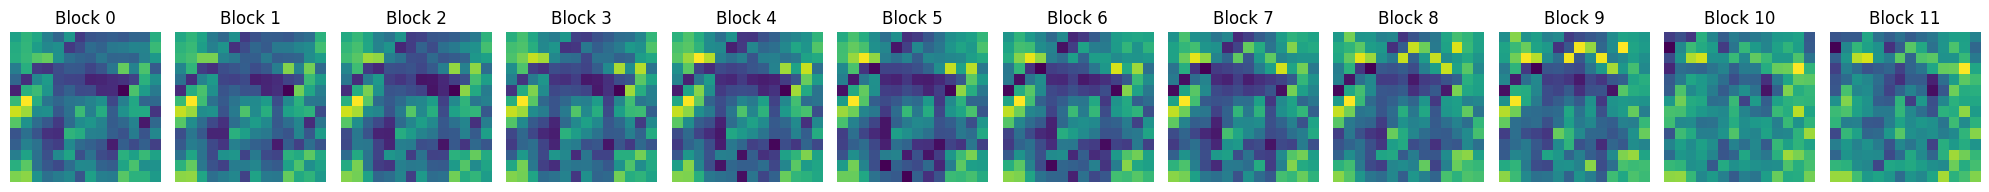

In [36]:
# Hook 함수 정의
feature_maps = []

def hook_fn(module, input, output):
    feature_maps.append(output)

# Transformer 블록에 Hook 등록
num_blocks = len(model.blocks)  # Transformer 블록의 개수를 자동으로 계산
for i in range(num_blocks):
    model.blocks[i].register_forward_hook(hook_fn)

# 모델 추론
with torch.no_grad():
    _ = model(img_tensor)

# Feature Maps 시각화
num_blocks = len(feature_maps)  # Transformer 블록의 수
fig, axes = plt.subplots(1, num_blocks, figsize=(20, 5))  # 가로로 블록 수만큼의 서브플롯 생성

for i, (ax, block_feature_map) in enumerate(zip(axes, feature_maps)):
    # 클래스 토큰 제거
    block_feature_map_patches = block_feature_map[0, 1:, :]  # [1, 197, 768] → [196, 768]

    # 14x14 형태로 변환
    patch_size = int(block_feature_map_patches.size(0) ** 0.5)  # 14 (CIFAR-10에서는 196 → 14x14)
    feature_map_2d = block_feature_map_patches.view(patch_size, patch_size, -1)

    # 평균값으로 축소하여 시각화
    feature_map_avg = feature_map_2d.mean(dim=-1).cpu().detach().numpy()

    # 서브플롯에 Feature Map 시각화
    ax.imshow(feature_map_avg, cmap='viridis')
    ax.set_title(f"Block {i}")
    ax.axis("off")  # 축 제거

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()